# Text Summarization & Tweeting an Impactful Tweet

## Setup
To prepare your environment, you need to install some packages.

### Install the necessary packages

You need the latest versions of these packages:<br>

In [10]:
!pip install gensim

In [11]:
!pip install watson-developer-cloud==1.5

In [12]:
!pip install pyldavis

In [13]:
!pip install wordcloud

In [14]:
from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords
import watson_developer_cloud
# import ibm_boto3
# from botocore.client import Config
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import urllib
from bs4 import BeautifulSoup
import requests
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/dsxuser/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/dsxuser/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /home/dsxuser/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to
[nltk_data]    |     /home/dsxuser/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     /home/dsxuser/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     /home/dsxuser/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to
[nltk_data]    |     /home/ds

[nltk_data]    | Downloading package shakespeare to
[nltk_data]    |     /home/dsxuser/nltk_data...
[nltk_data]    |   Unzipping corpora/shakespeare.zip.
[nltk_data]    | Downloading package sinica_treebank to
[nltk_data]    |     /home/dsxuser/nltk_data...
[nltk_data]    |   Unzipping corpora/sinica_treebank.zip.
[nltk_data]    | Downloading package smultron to
[nltk_data]    |     /home/dsxuser/nltk_data...
[nltk_data]    |   Unzipping corpora/smultron.zip.
[nltk_data]    | Downloading package state_union to
[nltk_data]    |     /home/dsxuser/nltk_data...
[nltk_data]    |   Unzipping corpora/state_union.zip.
[nltk_data]    | Downloading package stopwords to
[nltk_data]    |     /home/dsxuser/nltk_data...
[nltk_data]    |   Unzipping corpora/stopwords.zip.
[nltk_data]    | Downloading package subjectivity to
[nltk_data]    |     /home/dsxuser/nltk_data...
[nltk_data]    |   Unzipping corpora/subjectivity.zip.
[nltk_data]    | Downloading package swadesh to
[nltk_data]    |     /home/d

True

## 1. Summarization & keywords extraction

### 1a. Helper functions to extract summary and keywords

In [15]:
'''Get the summary of the text'''

def get_summary(text, pct):
    summary = summarize(text,ratio=pct,split=True)
    return summary

def complete_summary(summary):
    summary = " ".join(summary)
    print(type(summary))
    return summary

'''Get the keywords of the text'''

def get_keywords(text):
    res = keywords(text, ratio=0.1, words=None, split=False, scores=False, pos_filter=('NN', 'JJ'), lemmatize=False, deacc=False)
    res = res.split('\n')
    return res

'''Tokenize the sentence into words & remove punctuation'''

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def split_sentences(text):
    """ Split text into sentences.
    """
    sentence_delimiters = re.compile(u'[\\[\\]\n.!?]')
    sentences = sentence_delimiters.split(text)
    return sentences

def split_into_tokens(text):
    """ Split text into tokens.
    """
    tokens = nltk.word_tokenize(text)
    return tokens
    
def POS_tagging(text):
    """ Generate Part of speech tagging of the text.
    """
    POSofText = nltk.tag.pos_tag(text)
    return POSofText

def extract_title_text(url):
    page = urllib.request.urlopen(url).read().decode('utf8')
    soup = BeautifulSoup(page,'lxml')
    text = ' '.join(map(lambda p: p.text, soup.find_all('p')))
    return soup.title.text, text

### 1b. Summarization & keywords extraction

In [40]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_6b4ef4db85984d6cb9f05ef0da73c427 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='Mfkrien7_WF2rNDAEHoJEHHrKvXHZANIcPRqsHeuZPFW',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_6b4ef4db85984d6cb9f05ef0da73c427.get_object(Bucket='submissionanalysis-donotdelete-pr-jdnlxbx7mat2e1',Key='ProblemSolutionDBData.json')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object 

if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face an error during data loading.
# Please read the documentation of 'pandas.read_json()' and 'pandas.io.json.json_normalize' to learn more about the possibilities to adjust the data loading.
# pandas documentation: http://pandas.pydata.org/pandas-docs/stable/io.html#io-json-reader
# and http://pandas.pydata.org/pandas-docs/stable/generated/pandas.io.json.json_normalize.html

#print(body)
#df_data_1 = pd.read_json(body, orient='values')
df_data_1 = pd.read_json(body)
#df_data_1.head()
rawtext = ' '
problem = df_data_1["PROBLEM"]["uploads"][1]["text"]
solution = df_data_1["SOLUTION"]["uploads"][1]["text"]
comments = df_data_1['SOLUTION']["comments"]
for c in comments:
    rawtext = rawtext + c['comment'] + ' '
print(rawtext)

print ('-------------------------------------------------------------------------------------------------------------------')
print('Printing Summary')
print('--------------------------')

summary = get_summary(rawtext, 0.13)
print(summary)

print ('-------------------------------------------------------------------------------------------------------------------')
print ('-------------------------------------------------------------------------------------------------------------------')
print('Printing Keywords')
print('--------------------------')
hashtag_list =[]
for i in get_keywords(rawtext):
    hashtag = '#'+i
    hashtag_list.append(hashtag)
    
hashtag_string = str(" ".join(hashtag_list))
print(hashtag_string)
print ('-------------------------------------------------------------------------------------------------------------------')

 great idea! Wow, wish I had thought of this. Excellent idea. Do not forget! The tables should be 6 feet apart as well. Nice, I would never have thought of using shower curtains as partitions. That is an excellent idea. Maybe some kind of pulley system could be used here to open the curtains safely, or maybe a button? I like this a lot! This is also a good idea for nail salons Cleaning a shower curtain is a lot easier than cleaning other surfaces. It is cheap and affordable way to achieve social distancing while ensuring safety I could use this in my hair salon! It is a cheap and affordable option while maintaining social distancing. It has a high safety factor Owners could get creative with the curtain designs - maybe put menus on them? It can achieve high safety in an affordable way while being creative Love the creativity of this idea, how did you come up with it?? It is cheap and affordable This is a great creative idea so we can go back to restaurants! I would like to visit asap .

# 2. Topic Modelling

# 2a. Start the preprocessing for Topic Modelling

Topic Modelling is an approach for finding topics in large amounts of text. Topic modeling is great for document clustering, information retrieval from unstructured text, and feature selection.
 
Topic Modeling with Latent Dirichlet Allocation technique.

Why Latent Dirichlet Allocation? This technique can create model which can be generalized easily on any new text corpus and help us in identifying the important topics from the corpus. 

Some of the advantages are :

Training documents may come in sequentially, no random access required.

Runs in constant memory w.r.t. the number of documents: size of the training corpus does not affect memory footprint, can process corpora larger than RAM.

Is distributed & makes use of a cluster of machines, if available, to speed up model estimation.

In [41]:
# article_text = summary
stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()
filteredtext = rawtext
filteredtext = filteredtext.replace('the', '')
filteredtext = filteredtext.replace('It', '')
filteredtext = filteredtext.replace('may', '')
filteredtext = filteredtext.replace('maybe', '')
filteredtext = filteredtext.replace('wish', '')

word_tokens = word_tokenize(str(filteredtext)) 
filtered_sentence = [w for w in word_tokens if not w in stop_words]
normalized = " ".join(lemma.lemmatize(word) for word in filtered_sentence)

# 3. Visualization

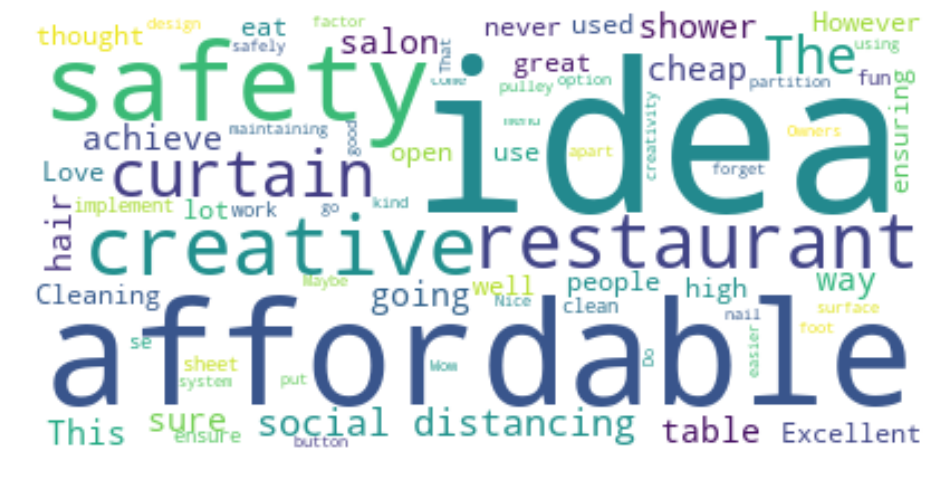

In [42]:
from wordcloud import WordCloud
#wordcloud = WordCloud(background_color='white',max_font_size=60).generate(normalized)

wordcloud = WordCloud(background_color="white", max_words=70, contour_width=10, contour_color='firebrick').generate(normalized)

plt.figure(figsize=(16,12))

'''plot wordcloud in matplotlib'''

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### 4. Create Topic Model

In [10]:
tokenized_sents = list(sent_to_words(filtered_sentence))
print(tokenized_sents)

# Creating the term dictionary of our corpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(tokenized_sents)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in tokenized_sents]
print(doc_term_matrix)

[['my'], ['restaurant'], ['struggling'], ['since'], ['covid'], ['hit'], [], ['want'], ['make'], ['people'], ['feel'], ['safe'], ['visit'], [], [], ['want'], ['prevent'], ['spread'], ['virus'], ['much'], ['possible'], [], ['your'], ['restaurant'], ['could'], ['use'], ['shower'], ['curtains'], ['partitions'], ['tables'], [], ['you'], ['could'], ['also'], ['use'], ['shower'], ['curtains'], ['seperate'], ['tables'], ['positioned'], ['farther'], ['away'], [], ['this'], ['way'], [], ['could'], ['easily'], ['moved'], ['around'], ['needed'], ['would'], ['easy'], ['clean'], [], ['before'], ['putting'], ['new'], ['party'], ['table'], [], ['curtains'], ['could'], ['sprayed'], ['wiped'], [], ['the'], ['curtains'], ['would'], ['catch'], ['droplets'], ['talking'], [], ['sneezing'], [], ['etc'], [], ['might'], ['come'], ['people'], ['eating'], ['restaurant'], [], ['this'], ['assure'], ['customers'], ['safe'], ['dine'], ['restaurant'], [], ['in'], ['addition'], [], ['customers'], ['look'], ['online'],

In [11]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Training LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=1, id2word = dictionary, passes=30)

# Print the model output
topics = ldamodel.print_topics(num_words=10)



In [12]:
print(topics)


[(0, '0.024*"idea" + 0.022*"restaurant" + 0.017*"table" + 0.015*"curtains" + 0.013*"could" + 0.013*"also" + 0.013*"the" + 0.010*"shower" + 0.010*"use" + 0.010*"customers"')]


In [13]:
for i in topics:
    print(i[1].split('"')[0])

0.024*


In [14]:
print ('---------------------------------------')
tweet_with_summary_hashtags = complete_summary(summary) + " "+hashtag_string
print(len(tweet_with_summary_hashtags))
print(tweet_with_summary_hashtags)


---------------------------------------
<class 'str'>
764
My restaurant has been struggling since covid hit and I want to make people feel safe to visit. I want to prevent the spread of the virus as much as possible!Your restaurant could use shower curtains as partitions between tables. Each waiter also makes sure the customers at their table use hand sanitiser as they finish their dinner and before they leave. The waiter is also responsible for cleaning the table, chair well before next customer comes in. This is also a good idea for nail salons Cleaning a shower curtain is a lot easier than cleaning other surfaces I could use this in my hair salon! Will restaurants clean these shower curtains often? #tables #table #customers #customer #use #uses #salons #salon #curtains #curtain #idea #clean #cleaning #people


#### Coherence score is 'higher the better' metric and given the score of 0.86 we can be assured that we have selected the right number of topics for this corpus.

In [ ]:
'''Compute Perplexity'''

# a measure of how good the model is. Lower the better.
print('\nPerplexity: ', ldamodel.log_perplexity(doc_term_matrix))

'''Compute Coherence Score'''

coherence_model_lda = CoherenceModel(model=ldamodel, texts=tokenized_sents, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

### We have seen how to summarize & visualize a document as well as a news article to get quick information about the data. This methodology can be applied to lot of usecases to extract insights from unstructured data.

### 5. Tweeting it on twitter

In [ ]:
consumer_key = '<Enter your consumer key>'
consumer_secret = '<Enter your consumer secret>'
access_token = '<Enter your access token>'
access_token_secret = '<enter your access token secret>'

In [ ]:
import tweepy

# Twitter requires oAuth2 to access its API:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [ ]:
status = api.update_status(tweet_with_summary_hashtags)
print(status.id) 